In [887]:
import numpy as np
from sympy.core import symbols
from sympy import simplify, cancel, Poly, fraction
from scipy.linalg import hankel
import matplotlib.pyplot as plt
import time


def dft_slow(src_data):
    _N = len(src_data) - 1
    _fw = np.zeros(_N, dtype=complex)
    for _k in range(_N):
        for _n in range(_N):
            _fw[_k] += src_data[_n] * np.e ** (1j * 2 * np.pi / _N * _n * _k)
    gain = [abs(_) for _ in _fw]
    return gain


def dft_vectorized(x):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    _N = x.shape[0]
    n = np.arange(_N)
    k = n.reshape((_N, 1))
    _M = np.exp(-2j * np.pi * k * n / _N)
    return np.dot(_M, x)


def fft_slow(x):
    """A recursive implementation of the 1D Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    _N = x.shape[0]

    if _N % 2 > 0:
        raise ValueError("size of x must be a power of 2")
    elif _N <= 32:  # this cutoff should be optimized
        return dft_vectorized(x)
    else:
        _X_even = fft_slow(x[::2])
        _X_odd = fft_slow(x[1::2])
        _factor = np.exp(-2j * np.pi * np.arange(_N) / _N)
        return np.concatenate([_X_even + _factor[:int(_N / 2)] * _X_odd,
                               _X_even + _factor[int(_N / 2):] * _X_odd])


def _fft(x):
    """A vectorized, non-recursive version of the Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    _N = x.shape[0]

    if np.log2(_N) % 1 > 0:
        raise ValueError("size of x must be a power of 2")

    # _N_min here is equivalent to the stopping condition above,
    # and should be a power of 2
    _N_min = min(_N, 32)

    # Perform an O[N^2] DFT on all length-_N_min sub-problems at once
    n = np.arange(_N_min)
    k = n[:, None]
    _M = np.exp(-2j * np.pi * n * k / _N_min)
    _X = np.dot(_M, x.reshape((_N_min, -1)))

    # build-up each level of the recursive calculation all at once
    while _X.shape[0] < _N:
        _X_even = _X[:, :int(_X.shape[1] / 2)]
        _X_odd = _X[:, int(_X.shape[1] / 2):]
        _factor = np.exp(-1j * np.pi * np.arange(_X.shape[0])
                         / _X.shape[0])[:, None]
        _X = np.vstack([_X_even + _factor * _X_odd,
                        _X_even - _factor * _X_odd])

    return _X.ravel()


def hann(x):
    x = np.array(x)
    _N = len(x)
    _hann_window = 0.53836 - 0.46164 * np.cos(2 * np.pi * np.arange(_N) / _N)
    x = x * _hann_window

    return x

def anti_hann(x):
    x = np.array(x)
    _N = len(x)
#     _hann_window = 0.53836 - 0.46164 * np.cos(2 * np.pi * np.arange(_N) / _N)
    _hann_window = 0.5 * (1 + np.cos(2 * np.pi * np.arange(_N) / (_N - 1)))
    x = x * _hann_window

    return x
    

def half_hann(x):
    x = np.array(x)
    _N = len(x)
    _hann_window = 0.53836 + 0.46164 * np.cos(np.pi * np.arange(_N) / (_N - 1))

    x = x * _hann_window
    return x


def padding(x):
    _N = len(x)
    _N_padding = int(2 ** np.ceil(np.log2(_N)))
    x_padding = np.pad(x, (0, _N_padding - _N))
    return x_padding


def fft(x, dt, window=None, plot=False):
    if window is None:
        pass
    elif window=='hann':
        x = hann(x)
    elif window=='half_hann':
        x = half_hann(x)
        
    x_padding = padding(x)
    _N_padding = len(x_padding)
    fs = 1 / (_N_padding * dt)
    f_padding = fs * np.arange(_N_padding)

    fw_padding = _fft(x_padding)

    if plot:
        plt.figure(figsize=(15, 4))
        plt.subplot(121)
        plt.plot(x)
        plt.subplot(122)
        plt.plot(f_padding, np.abs(fw_padding))
        plt.show()
    return f_padding, fw_padding


class TransferFunc(object):
    def __init__(self, nom, den, _dt):

        self.nom = nom
        self.den = den
        z = symbols('z')
        _nom_d = _den_d = 0
        for _i in range(len(nom)):
            _nom_d += nom[-_i - 1] * (2 / _dt * (z - 1) / (z + 1)) ** _i
        for _i in range(len(den)):
            _den_d += den[-_i - 1] * (2 / _dt * (z - 1) / (z + 1)) ** _i
        sys_d = cancel(simplify(_nom_d / _den_d))
        self.nom_d = Poly(fraction(sys_d)[0], z).all_coeffs()
        self.den_d = Poly(fraction(sys_d)[1], z).all_coeffs()
        self.input_array = np.zeros_like(self.nom_d)
        self.output_array = np.zeros_like(self.den_d)
        self.output = 0

    def response(self, _input_sig):
        self.input_array = np.delete(np.insert(self.input_array, 0, _input_sig), -1)
        self.output_array = np.delete(np.insert(self.output_array, 0, 0), -1)
        self.output = (np.dot(self.input_array, self.nom_d) -
                       np.dot(self.output_array[1::], self.den_d[1::])) / self.den_d[0]
        self.output_array[0] = self.output
        return self.output

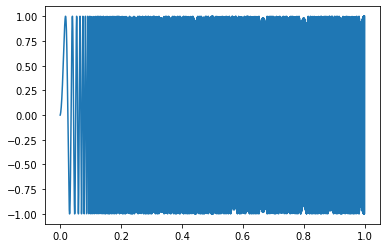

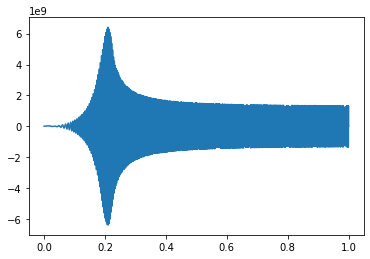

In [944]:
%matplotlib inline
dt = 1/6000
T = 1
#f = 20
t_list = np.arange(0, T, dt)

f_chirp_start = 1
f_chirp_end = 1500


_f_chirp_start = f_chirp_start
_f_chirp_end = f_chirp_end

u = np.sin(2 * np.pi * ((_f_chirp_end - _f_chirp_start) / T *
                            t_list ** 2 / 2 + _f_chirp_start * t_list))

res_freq = 300
anti_res_freq = 50
res_omega = res_freq * 2 * np.pi
anti_res_omega = anti_res_freq * 2 * np.pi


beta1 = 0.1
beta2 = 0.1

sys = TransferFunc(res_omega**2/anti_res_omega**2*np.array([1,2*beta1*anti_res_omega,anti_res_omega**2]),\
                        np.array([1,2*beta2*res_omega,res_omega**2]), dt)

# sys = TransferFunc(np.array([1,2,1]), np.array([1,0,1]), dt)

p = np.array([0])
v = np.array([0])
a = np.array([])

for i in range(len(u)):
    input_sig = u[i]
    a_current = sys.response(input_sig)#+random.normal()/4/5
    a = np.append(a, a_current)
    v_current = v[-1] + a_current * (1/dt)
    v = np.append(v, v_current)
    p_current = p[-1] + v_current * (1/dt)#+random.normal()/4/100
    p = np.append(p, p_current)

p = np.delete(p, 0)
v = np.delete(v, 0)
y = np.array(p, dtype=float)

y = np.pad(np.diff(y,2),(0,2))

plt.plot(t_list, u)
plt.show()
plt.plot(t_list, y)
plt.show()

u_detrend = u - np.mean(u)
y_detrend = y - np.mean(y)

# u_detrend = np.append(np.flip(u_detrend),u_detrend)
# y_detrend = np.append(np.flip(y_detrend),y_detrend)
# u_detrend = np.append(u_detrend,np.flip(u_detrend))
# y_detrend = np.append(y_detrend,np.flip(y_detrend))

In [945]:
Ruu = (np.array((np.mat(u_detrend) * np.mat(hankel(u_detrend)))).flatten())/np.flip(np.arange(len(u_detrend))+1)
Ryy = (np.array((np.mat(y_detrend) * np.mat(hankel(y_detrend)))).flatten())/np.flip(np.arange(len(u_detrend))+1)
Ruy = (np.array((np.mat(u_detrend) * np.mat(hankel(y_detrend)))).flatten())/np.flip(np.arange(len(u_detrend))+1)
Ryu = (np.array((np.mat(y_detrend) * np.mat(hankel(u_detrend)))).flatten())/np.flip(np.arange(len(u_detrend))+1)

In [946]:
f_u, fw_u = fft(u, dt)
f_y, fw_y = fft(y, dt)
f_h_u, fw_h_u = fft(hann(u), dt)
f_h_y, fw_h_y = fft(hann(y), dt)
f_hh_u, fw_hh_u = fft(half_hann(u), dt)
f_hh_y, fw_hh_y = fft(half_hann(y), dt)
f_ah_u, fw_ah_u = fft(anti_hann(u), dt)
f_ah_y, fw_ah_y = fft(anti_hann(y), dt)
f_Ruu, fw_Ruu = fft(Ruu, dt)
f_Ryy, fw_Ryy = fft(Ryy, dt)
f_Ruy, fw_Ruy = fft(Ruy, dt)
f_Ryu, fw_Ryu = fft(Ryu, dt)
ah_Ruu = anti_hann(Ruu)
ah_Ryy = anti_hann(Ryy)
ah_Ruy = anti_hann(Ruy)
ah_Ryu = anti_hann(Ryu)
f_ah_Ruu, fw_ah_Ruu = fft(ah_Ruu, dt)
f_ah_Ryy, fw_ah_Ryy = fft(ah_Ryy, dt)
f_ah_Ruy, fw_ah_Ruy = fft(ah_Ruy, dt)
f_ah_Ryu, fw_ah_Ryu = fft(ah_Ryu, dt)
h_Ruu = hann(Ruu)
h_Ryy = hann(Ryy)
h_Ruy = hann(Ruy)
h_Ryu = hann(Ryu)
f_h_Ruu, fw_h_Ruu = fft(h_Ruu, dt)
f_h_Ryy, fw_h_Ryy = fft(h_Ryy, dt)
f_h_Ruy, fw_h_Ruy = fft(h_Ruy, dt)
f_h_Ryu, fw_h_Ryu = fft(h_Ryu, dt)

# fold_ah_Ruu = np.append(np.flip(ah_Ruu),ah_Ruu)
# fold_ah_Ryy = np.append(np.flip(ah_Ryy),ah_Ryy)
# fold_ah_Ruy = np.append(np.flip(ah_Ruy),ah_Ruy)
# fold_ah_Ryu = np.append(np.flip(ah_Ryu),ah_Ryu)
fold_ah_Ruu = np.append(ah_Ruu,np.flip(ah_Ruu))
fold_ah_Ryy = np.append(ah_Ryy,np.flip(ah_Ryy))
fold_ah_Ruy = np.append(ah_Ruy,np.flip(ah_Ruy))
fold_ah_Ryu = np.append(ah_Ryu,np.flip(ah_Ryu))
f_fold_ah_Ruu, fw_fold_ah_Ruu = fft(fold_ah_Ruu, dt)
f_fold_ah_Ryy, fw_fold_ah_Ryy = fft(fold_ah_Ryy, dt)
f_fold_ah_Ruy, fw_fold_ah_Ruy = fft(fold_ah_Ruy, dt)
f_fold_ah_Ryu, fw_fold_ah_Ryu = fft(fold_ah_Ryu, dt)

# fold_Ruu = np.append(np.flip(Ruu),Ruu)
# fold_Ryy = np.append(np.flip(Ryy),Ryy)
# fold_Ruy = np.append(np.flip(Ruy),Ruy)
# fold_Ryu = np.append(np.flip(Ryu),Ryu)
fold_Ruu = np.append(Ruu,np.flip(Ruu))
fold_Ryy = np.append(Ryy,np.flip(Ryy))
fold_Ruy = np.append(Ruy,np.flip(Ruy))
fold_Ryu = np.append(Ryu,np.flip(Ryu))
f_fold_Ruu, fw_fold_Ruu = fft(fold_Ruu, dt)
f_fold_Ryy, fw_fold_Ryy = fft(fold_Ryy, dt)
f_fold_Ruy, fw_fold_Ruy = fft(fold_Ruy, dt)
f_fold_Ryu, fw_fold_Ryu = fft(fold_Ryu, dt)

In [947]:
resolution = 1/dt/len(f_u)
start_point=int(f_chirp_start/resolution)
end_point=int(f_chirp_end/resolution)

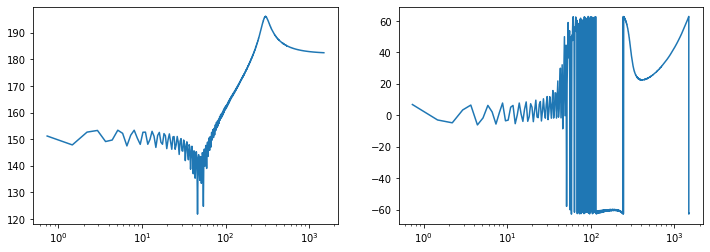

In [948]:
# %matplotlib notebook
%matplotlib inline

resolution = 1/dt/len(f_u)
start_point=int(f_chirp_start/resolution)
end_point=int(f_chirp_end/resolution)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.xscale('log')
plt.plot(f_u[start_point:end_point],\
        20*np.log10(np.abs(fw_y)[start_point:end_point] / \
                    np.abs(fw_u)[start_point:end_point]))

plt.subplot(122)
plt.xscale('log')
plt.plot(f_u[start_point:end_point],\
         20*np.angle((fw_y)[start_point:end_point] / \
                     (fw_u)[start_point:end_point]))
plt.show()

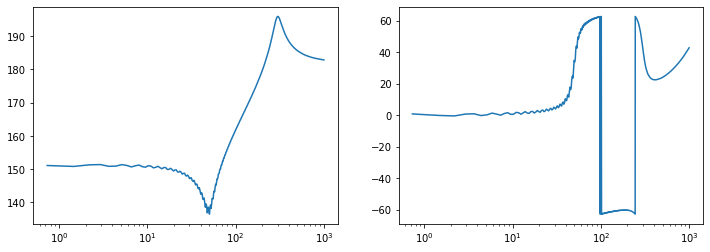

In [943]:
# %matplotlib notebook
%matplotlib inline

resolution = 1/dt/len(f_u)
start_point=int(f_chirp_start/resolution)
end_point=int(f_chirp_end/resolution)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.xscale('log')
plt.plot(f_hh_u[start_point:end_point],\
        20*np.log10(np.abs(fw_hh_y)[start_point:end_point] / \
                    np.abs(fw_hh_u)[start_point:end_point]))

plt.subplot(122)
plt.xscale('log')
plt.plot(f_hh_u[start_point:end_point],\
         20*np.angle((fw_hh_y)[start_point:end_point] / \
                     (fw_hh_u)[start_point:end_point]))
plt.show()

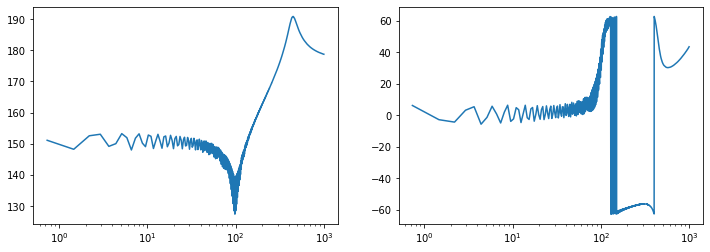

In [929]:
# %matplotlib notebook
%matplotlib inline

resolution = 1/dt/len(f_h_u)
start_point=int(f_chirp_start/resolution)
end_point=int(f_chirp_end/resolution)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.xscale('log')
plt.plot(f_h_u[start_point:end_point],\
        20*np.log10(np.abs(fw_h_y)[start_point:end_point] / \
                    np.abs(fw_h_u)[start_point:end_point]))

plt.subplot(122)
plt.xscale('log')
plt.plot(f_h_u[start_point:end_point],\
         20*np.angle((fw_h_y)[start_point:end_point] / \
                     (fw_h_u)[start_point:end_point]))
plt.show()

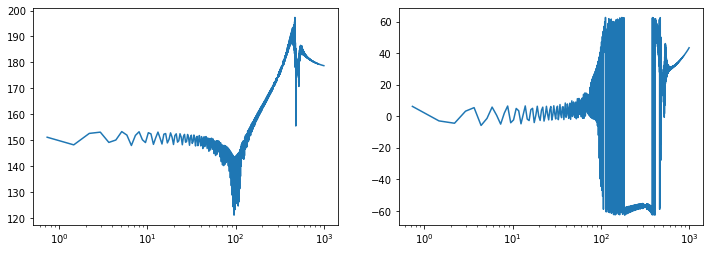

In [931]:
# %matplotlib notebook
%matplotlib inline

resolution = 1/dt/len(f_ah_u)
start_point=int(f_chirp_start/resolution)
end_point=int(f_chirp_end/resolution)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.xscale('log')
plt.plot(f_ah_u[start_point:end_point],\
        20*np.log10(np.abs(fw_ah_y)[start_point:end_point] / \
                    np.abs(fw_ah_u)[start_point:end_point]))

plt.subplot(122)
plt.xscale('log')
plt.plot(f_ah_u[start_point:end_point],\
         20*np.angle((fw_ah_y)[start_point:end_point] / \
                     (fw_ah_u)[start_point:end_point]))
plt.show()

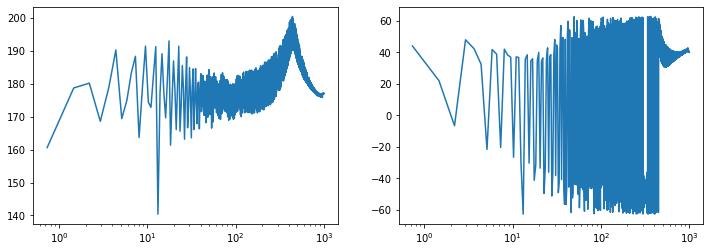

In [930]:
# %matplotlib notebook
# %matplotlib inline

resolution = 1/dt/len(f_h_Ruu)
start_point=int(f_chirp_start/resolution)
end_point=int(f_chirp_end/resolution)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.xscale('log')
plt.plot(f_h_Ruu[start_point:end_point],\
        20*np.log10(np.abs(fw_h_Ruy)[start_point:end_point] / \
                    np.abs(fw_h_Ruu)[start_point:end_point]))

plt.subplot(122)
plt.xscale('log')
plt.plot(f_h_Ruu[start_point:end_point],\
         20*np.angle((fw_h_Ruy)[start_point:end_point] / \
                     (fw_h_Ruu)[start_point:end_point]))
plt.show()

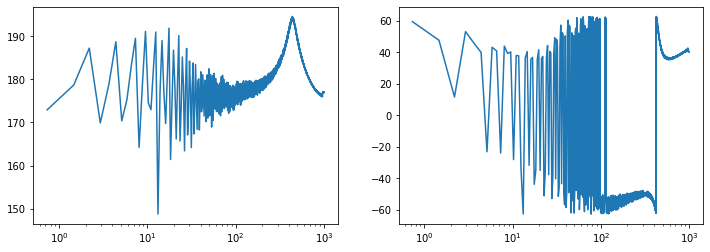

In [934]:
# %matplotlib notebook
# %matplotlib inline

resolution = 1/dt/len(f_Ruu)
start_point=int(f_chirp_start/resolution)
end_point=int(f_chirp_end/resolution)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.xscale('log')
plt.plot(f_Ruu[start_point:end_point],\
        20*np.log10(np.abs(fw_Ruy)[start_point:end_point] / \
        np.abs(fw_Ruu)[start_point:end_point]))

plt.subplot(122)
plt.xscale('log')
plt.plot(f_Ruu[start_point:end_point],\
         20*np.angle((fw_Ruy)[start_point:end_point] / \
                     (fw_Ruu)[start_point:end_point]))
plt.show()

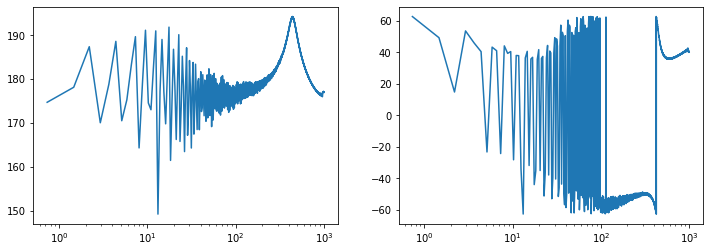

In [935]:
# %matplotlib notebook
# %matplotlib inline

resolution = 1/dt/len(f_ah_Ruu)
start_point=int(f_chirp_start/resolution)
end_point=int(f_chirp_end/resolution)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.xscale('log')
plt.plot(f_ah_Ruu[start_point:end_point],\
        20*np.log10(np.abs(fw_ah_Ruy)[start_point:end_point] / \
                    np.abs(fw_ah_Ruu)[start_point:end_point]))

plt.subplot(122)
plt.xscale('log')
plt.plot(f_ah_Ruu[start_point:end_point],\
         20*np.angle((fw_ah_Ruy)[start_point:end_point] / \
                     (fw_ah_Ruu)[start_point:end_point]))
plt.show()

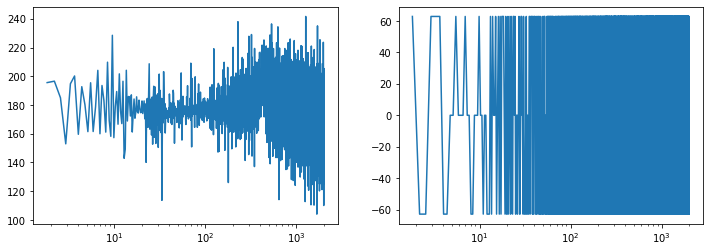

In [936]:
# %matplotlib notebook
# %matplotlib inline

resolution = 1/dt/len(f_fold_ah_Ruu)/2
start_point=int(f_chirp_start/resolution)
end_point=int(f_chirp_end/resolution)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.xscale('log')
plt.plot(f_fold_ah_Ruu[start_point:end_point],\
        20*np.log10(np.abs(fw_fold_ah_Ruy)[start_point:end_point] / \
                    np.abs(fw_fold_ah_Ruu)[start_point:end_point]))

plt.subplot(122)
plt.xscale('log')
plt.plot(f_fold_ah_Ruu[start_point:end_point],\
         20*np.angle((fw_fold_ah_Ruy)[start_point:end_point] / \
                     (fw_fold_ah_Ruu)[start_point:end_point]))
plt.show()

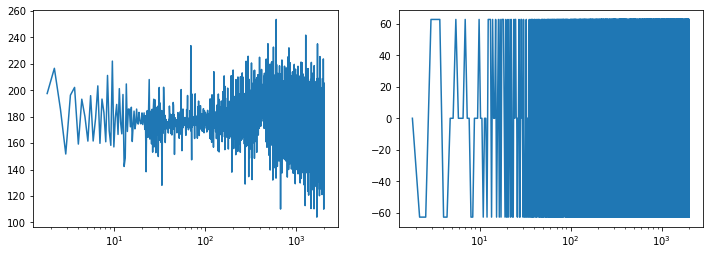

In [937]:
# %matplotlib notebook
# %matplotlib inline

resolution = 1/dt/len(f_fold_Ruu)/2
start_point=int(f_chirp_start/resolution)
end_point=int(f_chirp_end/resolution)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.xscale('log')
plt.plot(f_fold_Ruu[start_point:end_point],\
        20*np.log10(np.abs(fw_fold_Ruy)[start_point:end_point] / \
                    np.abs(fw_fold_Ruu)[start_point:end_point]))

plt.subplot(122)
plt.xscale('log')
plt.plot(f_fold_Ruu[start_point:end_point],\
         20*np.angle((fw_fold_Ruy)[start_point:end_point] / \
                     (fw_fold_Ruu)[start_point:end_point]))
plt.show()

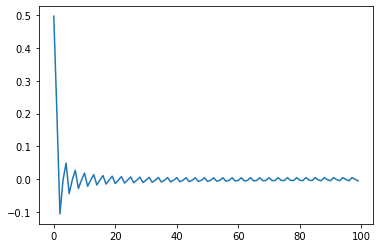

In [782]:
Ruu2 = (np.array((np.mat(np.append(u_detrend,np.flip(u_detrend))) * \
                 np.mat(hankel(np.append(u_detrend,np.flip(u_detrend)))))).flatten())/\
                np.flip(np.arange(len(np.append(u_detrend,np.flip(u_detrend))))+1)


plt.plot(Ruu2[0:100])

In [182]:
# %matplotlib notebook
sine_dt=1/800
sine_freq = 50  # 每秒一百个周期，每个周期 1/f [s] = 0.01[s]，T[s] 有 f * T = 10 个周期


T = 1/sine_freq*8
T = 0.1
t_list4sine = np.arange(0,T,sine_dt)  # 6000 个 samples


phase_delay = 90 * 2 * np.pi / 360
given_delay = phase_delay / 2 / np.pi * (1/sine_freq)


sine1=[np.sin(2 * np.pi * sine_freq * _) for _ in t_list4sine]
sine2=[1/3*np.sin(2 * np.pi * sine_freq * (_ - given_delay)) for _ in t_list4sine]
f_sine1, fw_sine1 = fft(sine1,sine_dt);
# plt.figure()
# plt.plot(sine1)
# plt.plot(sine2)
# plt.show()

In [183]:
time_start=time.time()
time_end=time.time()
print('time cost',time_end-time_start,'s')
print(T)
Rs1s2 = np.array((np.mat(sine1) * np.mat(hankel(sine2)))).flatten()

# plt.figure()
# plt.plot(Rs1s2)
# plt.show()

max_Rs1s2_index = np.where(Rs1s2==np.max(Rs1s2))

got_delay=max_Rs1s2_index[0]*sine_dt
print(given_delay, got_delay)

f_Rs1s2, fw_Rs1s2 = fft(Rs1s2,sine_dt)
fw_Rs1s2_shift = fw_Rs1s2[0:int(len(fw_Rs1s2)/2)]
max_sine_freq_index = np.where(np.abs(fw_Rs1s2_shift)==np.max(np.abs(fw_Rs1s2_shift)))
got_freq = f_Rs1s2[max_sine_freq_index[0]]
print(sine_freq, got_freq)
phase = got_delay / (1 / got_freq) * 2 * np.pi
print(given_delay/(1/sine_freq)*2*np.pi, phase)

time cost 4.38690185546875e-05 s
0.1
0.005 [0.005]
50 [50.]
1.5707963267948966 [1.57079633]


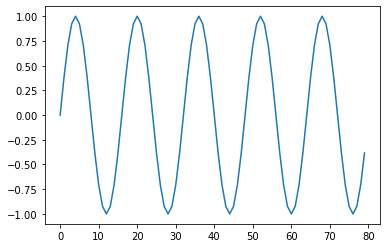

In [184]:
plt.plot(sine1)

<IPython.core.display.Javascript object>


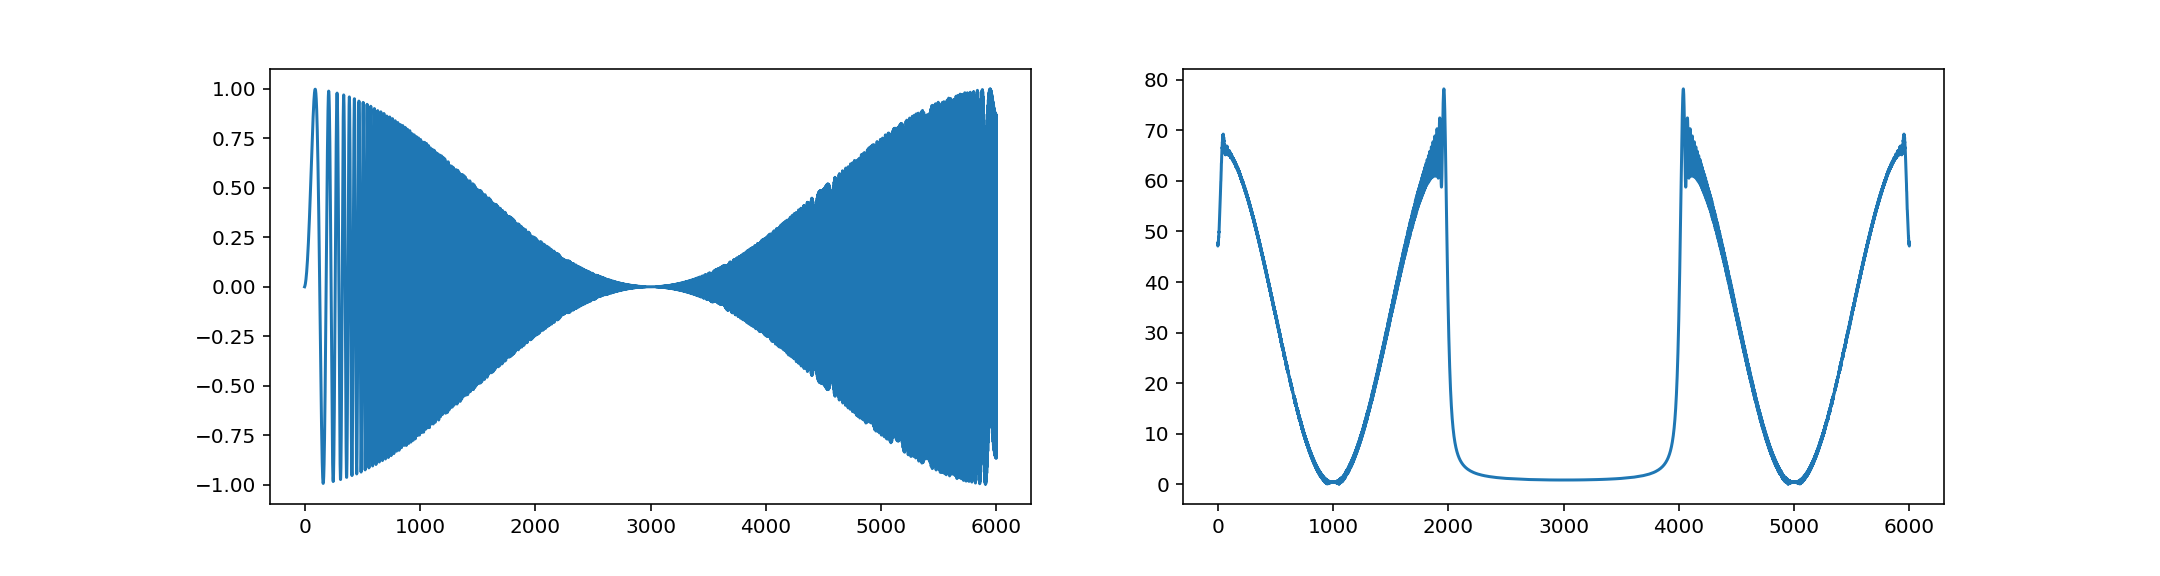

In [722]:
fft(anti_hann(u),dt,plot=True);

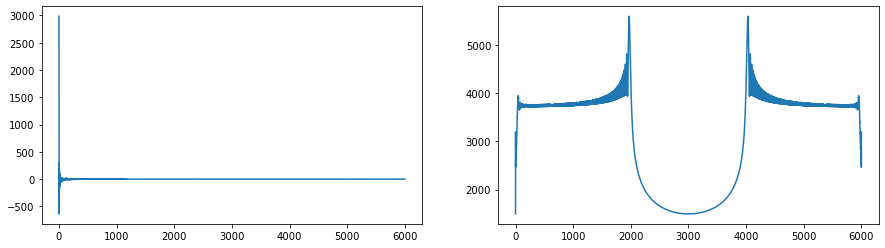

In [718]:
fft(Ruu,dt,plot=True);

<IPython.core.display.Javascript object>


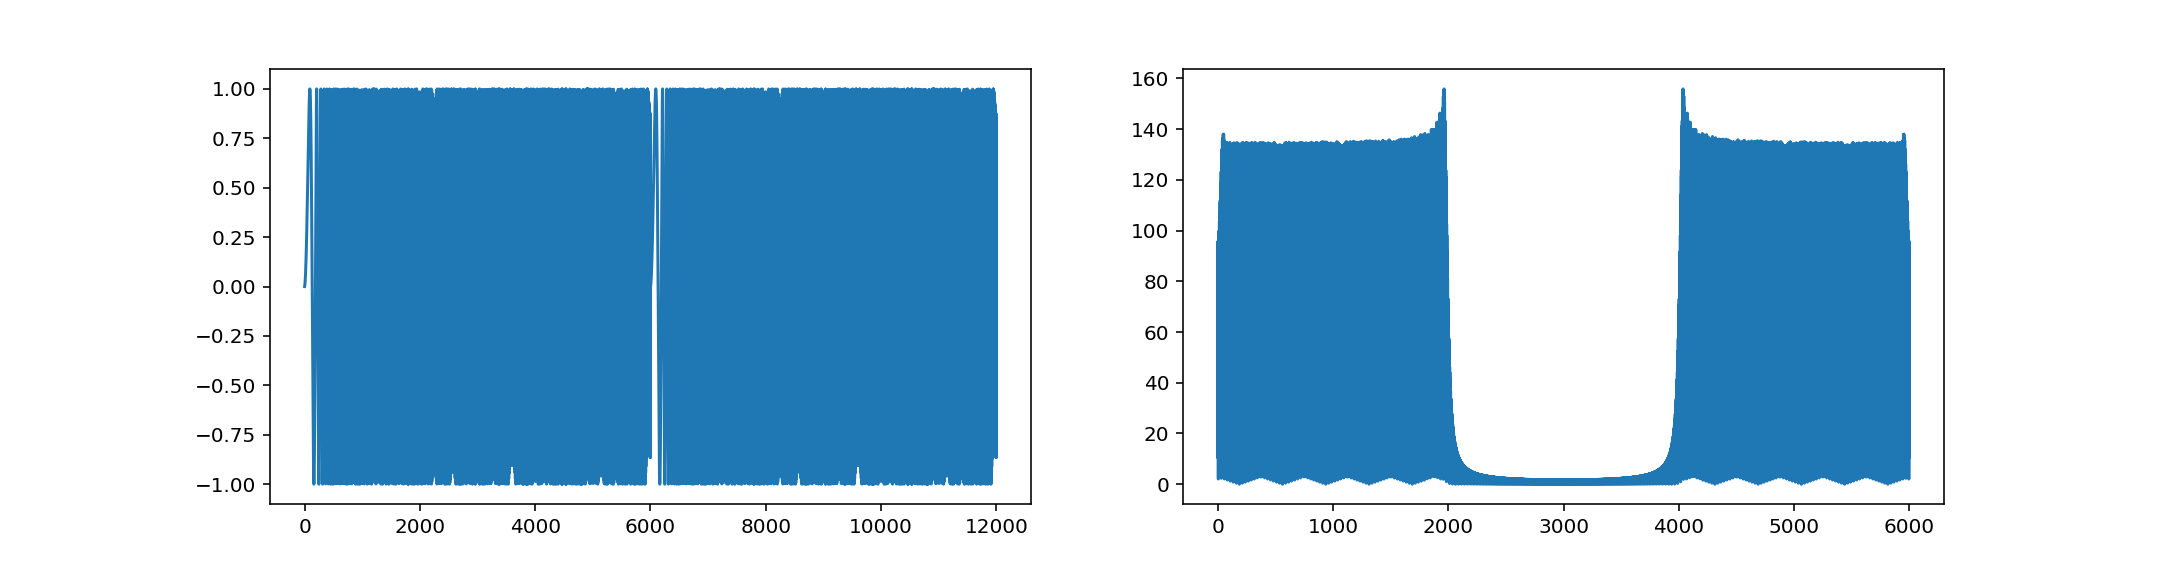

In [720]:
%matplotlib notebook
fft(np.append(u,u),dt,plot=True);

<IPython.core.display.Javascript object>


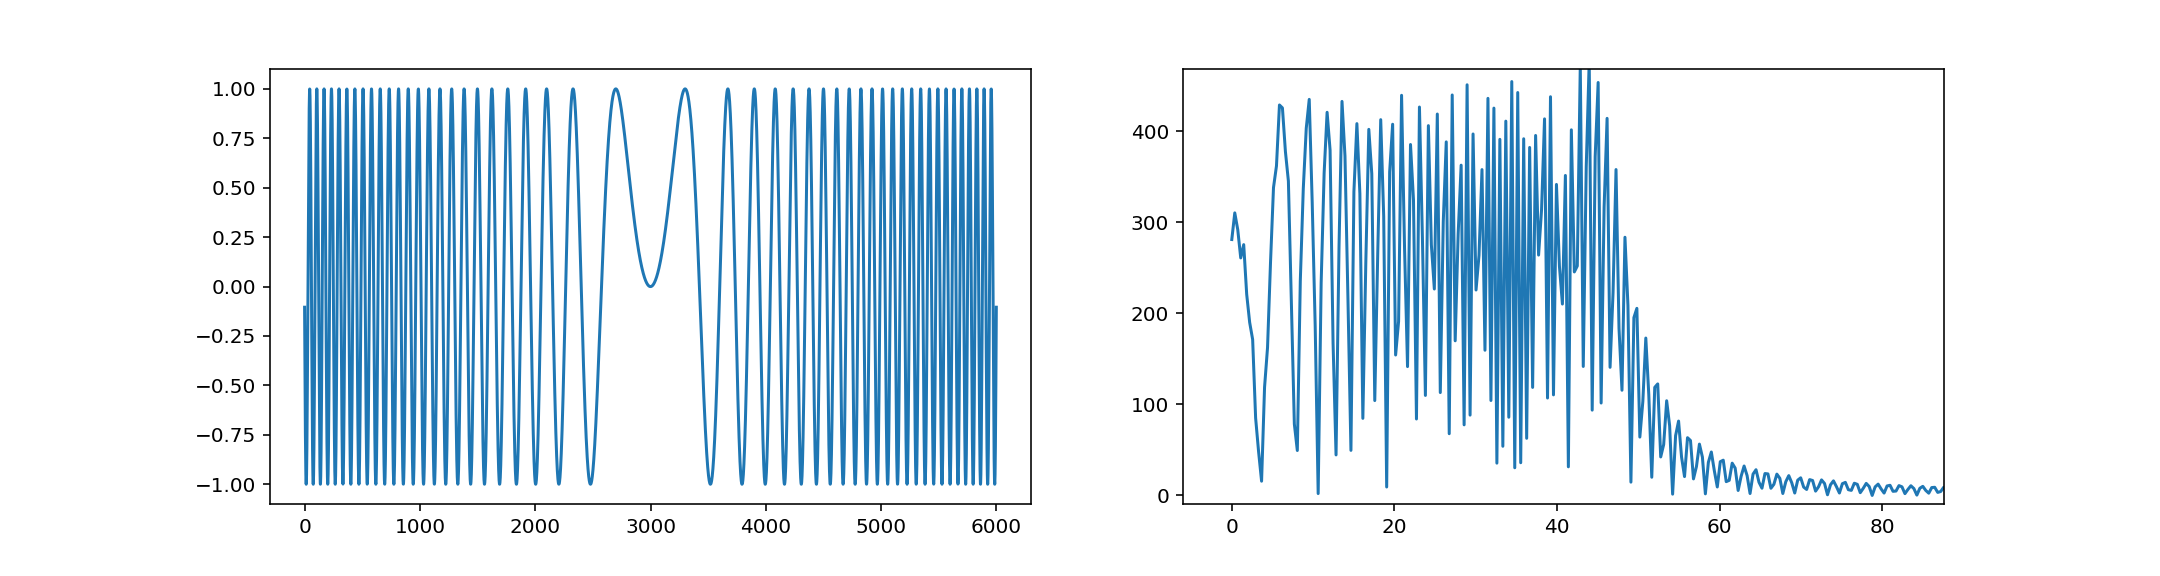

In [198]:
# %matplotlib notebook
%matplotlib inline
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

def draw_fft_animate(dt,T,f):

    t_list = np.arange(0,T,dt)
    u_raw = [sin(2*f * np.pi * _)+sin(2*2*f * np.pi * _) for _ in t_list]
    N=len(t_list)
    Hann_window = 0.53836 - 0.46164*np.cos(2 * np.pi * np.arange(N) / (N))
    u_Hann=u_raw*Hann_window
    N_padding=int(2**np.ceil(np.log2(N)))
    u_padding = np.pad(u_raw,(0,N_padding-N))
    u_Hann_padding = np.pad(u_Hann,(0,N_padding-N))

    fs=1/(N_padding*dt)
    f_padding=fs*np.arange(N_padding)

    Fw_Hann_padding = FFT(u_Hann_padding)
    plt.figure(figsize=(15,4))
    plt.subplot(121)
    plt.plot(u_raw)
    plt.subplot(122)
    plt.plot(f_padding,np.abs(Fw_Hann_padding))

interact(draw_fft_animate,
         dt = widgets.FloatSlider(value=0.01,min=0.0001,max=0.01, step=0.0001),
         T = widgets.FloatSlider(value=1,min=0.1,max=10.0, step=0.1),
         f = widgets.FloatSlider(value=15,min=0,max=50.0, step=1))

In [ ]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import control

# G = control.tf([1,100000],[1,100,300000])
G = control.tf([1],[1,1])


(num,den) = control.pade(0.25,3)
Gp = control.tf(num,den)*G
print(G)
# print(Gp)
mag,phase,omega = control.bode(G,Hz=True,dB=True)
#mag,phase,omega = control.bode(Gp,Hz=True)

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt

# sys = signal.TransferFunction([2000000], [200, 10000,3000000])
sys = signal.TransferFunction([1], [1,1])
res_freq = 450
anti_res_freq = 100
beta1 = 0.1
beta2 = 0.1

sys = signal.TransferFunction(np.array([1,2*beta1*anti_res_freq,anti_res_freq**2]),\
                        np.array([1,2*beta2*res_freq,res_freq**2]))
# sys = signal.TransferFunction(np.array([1,2,1]),\
#                         np.array([1,0,1]))
                              
# sys = signal.ZerosPolesGain([10], [5], 0.1)
w, mag, phase = signal.bode(sys)

plt.figure()
plt.semilogx(w, mag)    # Bode magnitude plot
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.show()